In [78]:
from pathlib import Path
from math import sqrt

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

### Generate dataset

In [79]:
def one_hot(n, i):
    q = np.zeros(n)
    q[i] = 1.0
    return q

In [80]:
img_size = 784
img_shape = (28, 28)

train_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_test.csv'), delimiter=',')

In [81]:
x_train = train_data[:,1:] / 255.0
y_train = np.array([one_hot(10, int(i)) for i in train_data[:,0]])

x_test = test_data[:,1:] / 255.0
y_test = np.array([one_hot(10, int(i)) for i in test_data[:,0]])

### Define functions

In [82]:
def one_hot(n: int, i: int) -> np.ndarray:
    q = np.zeros(n)
    q[i] = 1.0
    return q


@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return (a @ b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mcosim(m: np.ndarray, x: np.ndarray) -> float:
    y = np.zeros(m.shape[0])
    x_norm = norm(x)
    
    for i in range(m.shape[0]):
        y[i] = (m[i] @ x) / (norm(m[i]) * x_norm)
        
    return y


@njit(fastmath=True)
def project(x: np.ndarray, m: np.ndarray) -> np.ndarray:
    return (m @ x) / np.sum(m * m, axis=1)


@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [83]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray, W: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)

    for i in range(x_batch.shape[0]):
        h = W.T @ y_batch[i]
        # dh = dReLU(h)
        # x = V.T @ ReLU(h)
        x = V.T @ h

        dLdx = 2 * (x - x_batch[i])
        # dLdh = V @ dLdx * dh
        dLdh = V @ dLdx

        dLdV = np.outer(h, dLdx)
        dLdw = np.outer(y_batch[i], dLdh)

        dV += dLdV
        dW += dLdw

    return (dV, dW)


class Perceptron:
    def __init__(self, nIn: int, nH: int, nOut: int) -> None:
        self.nIn = nIn
        self.nH = nH
        self.nOut = nOut

        self.V: np.ndarray = np.random.uniform(-1, 1, (nH, nIn))
        self.W: np.ndarray = np.random.uniform(-1, 1, (nOut, nH))

    def predict(self, x: np.ndarray, n_iter: int = 8) -> np.ndarray:
        m = self.W @ self.V

        for i in range(n_iter):
            y = mcosim(m, x)
            # x = x + self.V @ y
            # x = x / np.linalg.norm(x)
            m = (y[:, np.newaxis] * self.W) @ self.V

        return y

    def loss(self, y_batch: np.ndarray, x_batch: np.ndarray) -> float:
        x_pred_batch = np.array([self.predict(y) for y in y_batch])
        d = np.sum(np.square(x_pred_batch - x_batch), axis=1)
        return np.mean(d)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dV, dW = grads(x_train[batch_idxs], y_train[batch_idxs], self.V, self.W)

                self.V -= lr * dV
                self.W -= lr * dW

### Create and train model

In [93]:
nIn = 784
nH = 8
nOut = 10

learning_rate = 1e-3
batch_size = 8
max_epoch = 64

model = Perceptron(nIn, nH, nOut)
model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

In [94]:
W = model.W
V = model.V

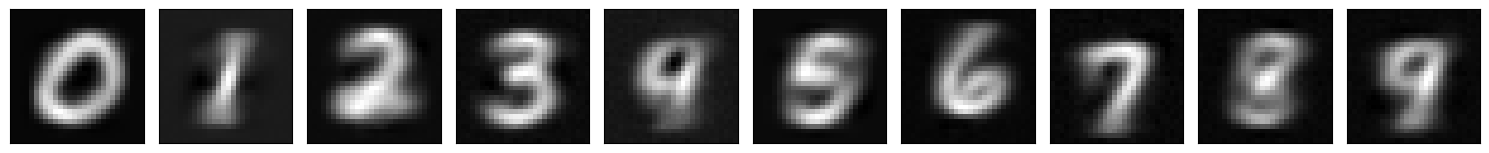

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=10)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.set_dpi(100)

for i, ax in enumerate(axes.ravel()):
    x = V.T @ W[i]
    # x = V.T @ ReLU(W[i])
    img = ax.imshow(x.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

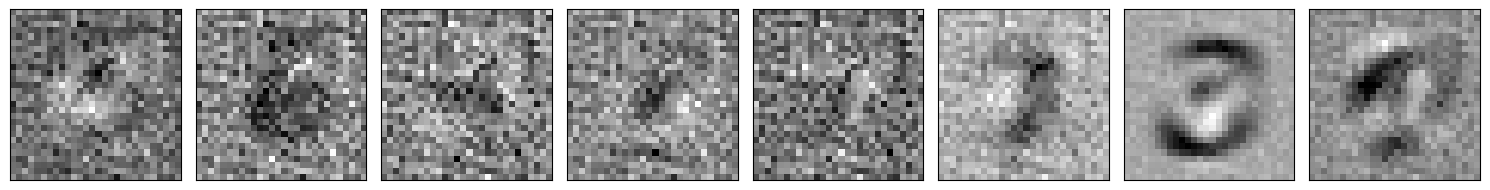

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=nH)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.set_dpi(100)

for i, ax in enumerate(axes.ravel()):
    img = ax.imshow(V[i].reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [97]:
c = model.W[0]

imgs = []

n_steps = 9
q = np.linspace(-1, 1, n_steps)

for i in range(nH):
    cur_imgs = []
    for j in range(n_steps):
        dc = q[j] * one_hot(nH, i)
        cur_imgs.append((c + dc) @ model.V)
    imgs.append(cur_imgs)

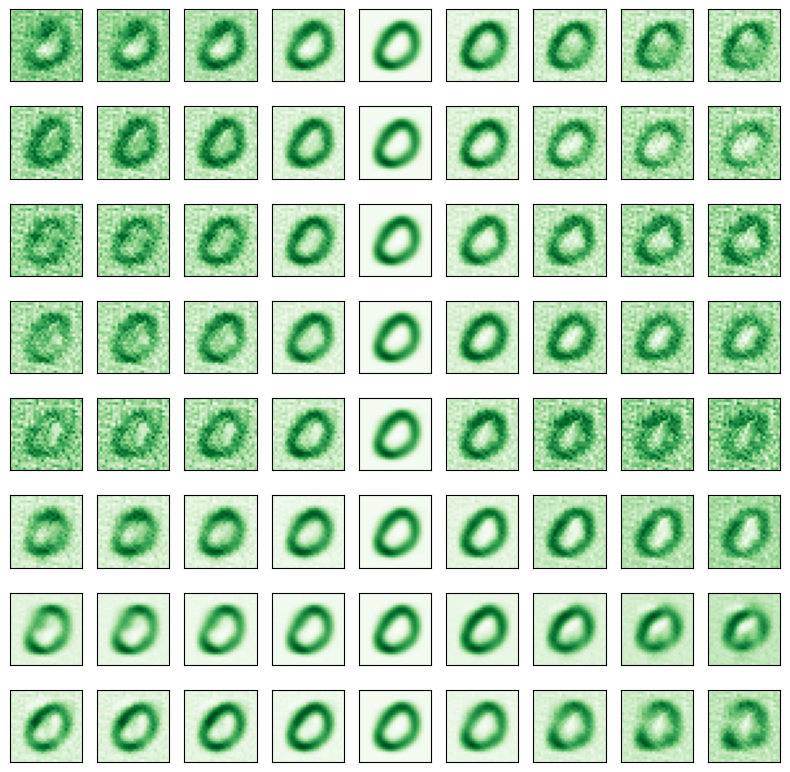

In [98]:
fig, axes = plt.subplots(nrows=nH, ncols=n_steps)
fig.set_figwidth(8)
fig.set_figheight(8)
fig.set_dpi(100)

for i in range(nH):
    for j in range(n_steps):
        axes[i][j].imshow(imgs[i][j].reshape(img_shape), cmap='Greens')
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

plt.tight_layout()
plt.show()